# Project 1

As discussed in class, two groups of asteroid accompanying the planet Jupiter in its orbit around the Sun—the Trojan asteroids. The two groups sit at points of stable equilibrium (the Lagrange points) preceding and trailing Jupiter at an angular distance of π/3 radians. The combination of the gravitational attraction of the Sun and Jupiter gives a resultant force on a Trojan asteroid towards the center of mass of the two bodies such that the centripetal acceleration causes the asteroid to orbit with the same period as the planet.

Note that units suitable for this system are normalized for the Solar System: the mass of the Sun (M⊙) is taken as unit mass, unit distance is the astronomical unit (AU), and unit time is one year. For such a system, the gravitational constant G is 4π2. The mass of Jupiter can be taken to be 0.001 M⊙ and the average distance of Jupiter from the Sun is 5.2 AU. The asteroids' masses are negligible in this system.

In [2]:
import matplotlib    # Library used for plotting
import numpy as np   # Numerical library
import matplotlib.pyplot as plt # Plot commands

import scipy         # Another numerical library
from scipy import integrate

# Define some colors using the RGB format

CF_red = (204/255, 121/255, 167/255)
CF_vermillion = (213/255, 94/255, 0)
CF_orange = (230/255, 159/255, 0)
CF_yellow = (240/255, 228/255, 66/255)
CF_green = (0, 158/255, 115/255)
CF_sky = (86/255, 180/255, 233/255)
CF_blue = (0, 114/255, 178/255)
CF_black = (0, 0, 0)

## Part 1 - Setup

Write a program to solve the equations of motion for this system numerically, and demonstrate that the asteroids will stay at the Lagrange points over many orbits of Jupiter around the Sun. This should show that your program is operating correctly with no numerical instabilities being propagated during the computation.

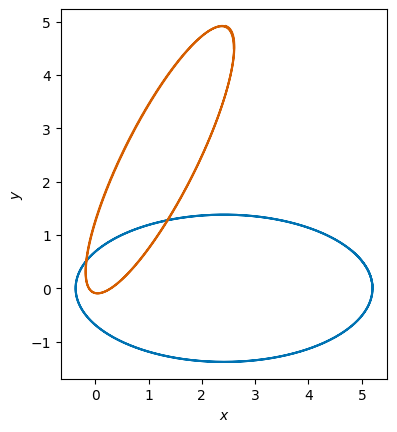

In [42]:
# Parameters
t_min = 0
t_max = 10 * 365.25
M_S = 1
M_J = 0.001
epsilon = 0.1

init = np.array([5.2, 0, 0, (1 / 365.25), # Jupiter
                 2.6, 4.5, 0, (1 / 365.25)]) # Asteroid L4
                #  2.6, -4.5, 0, (1 / 365.25)]) # Asteroid L5
                #  5.2 - 0.3604277601, 0, 0, (1 / 365.25)]) # Asteroid L1
                #  5.2 + 0.3604277601, 0, 0, (1 / 365.25)]) # Asteroid L2
                #  -5.2 - 0.003030303, 0, 0, (1 / 365.25)]) # Asteroid L3

# Functions

# d = G * M / AU^3 * 86400^2
d = -2.96 * 10 ** (-4)

def derivative(t, state):
    x_J, y_J, v_x_J, v_y_J, x_A, y_A, v_x_A, v_y_A = state

    # Distances
    r_JS = np.sqrt(x_J ** 2 + y_J ** 2)  # Distance from Jupiter to Sun
    r_AS = np.sqrt(x_A **2 + y_A **2)  # Distance from Asteroid to Sun
    r_AJ = np.sqrt((x_A - x_J) ** 2 + (y_A - y_J) ** 2)  # Distance from Asteroid to Jupiter

    # Accelerations
    a_x_JS = d * M_S * x_J / (r_JS ** 3)  # Jupiter's acceleration due to the Sun
    a_y_JS = d * M_S * y_J / (r_JS ** 3)

    a_x_AS = d * M_S * x_A / (r_AS ** 3)  # Asteroid's acceleration due to the Sun
    a_y_AS = d * M_S * y_A / (r_AS ** 3)

    a_x_AJ = d * M_J * (x_A - x_J) / (r_AJ ** 3)  # Asteroid's acceleration due to Jupiter
    a_y_AJ = d * M_J * (y_A - y_J) / (r_AJ ** 3)

    a_x_A = a_x_AS + a_x_AJ  # Total x acceleration of the Asteroid
    a_y_A = a_y_AS + a_y_AJ  # Total y acceleration of the Asteroid

    return np.array([v_x_J, v_y_J, a_x_JS, a_y_JS, v_x_A, v_y_A, a_x_A, a_y_A])

# Solution
solution = integrate.solve_ivp(derivative, [t_min, t_max], init, max_step = epsilon)

# Plot
x_1 = solution.y[0]
y_1 = solution.y[1]

x_2 = solution.y[4]
y_2 = solution.y[5]

fig, ax = plt.subplots(1, 1)
ax.plot(x_1, y_1, color = CF_blue)
ax.plot(x_2, y_2, color = CF_vermillion)
ax.set(xlabel = "$x$", ylabel = "$y$")
plt.gca().set_aspect("equal")

## Part 2 - Position Stability

Vary the initial positions of the asteroids and plot their positions through a few hundred orbits. Your results should show that they oscillate about the Lagrange points, but do not escape from the stable position. Considering both the leading and trailing groups, determine a way to quantitatively describe how far the stable orbits wander from the Lagrange points. Plot their wander as a function of their initial position perturbation.

## Part 3 - Velocity Stability

Give your particles some initial velocity relative to the Lagrange points. Determine the range of initial velocity vectors for which the orbits remain captured by the Lagrange points. 

## Part 4 - Mass Dependence

Similar "Trojan" asteroids are also present in the orbit of Mars. Run your program for a range of planetary masses (within two orders of magnitude of Jupiter's mass should work). Explore the range of distances that the asteroids wander as a function of the planetary mass.